In [1]:
###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from scipy.stats import norm

/home/mourad/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="GOOG" # Set up the symbol you want
kdays=30 # Number of days for forecasting

In [4]:
# Create folder for symbol
symbolFolder="results/ARIMA/"+symbol
os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

      symbol  quotedate        open        high         low       close  \
0         BA 2015-05-26  144.339996  144.429993  142.160004  142.800003   
1         BA 2015-06-18  143.910004  146.529999  143.910004  145.380005   
2         BA 2015-06-26  143.029999  143.039993  141.889999  142.479996   
3         BA 2016-02-09  117.980003  119.980003  117.430000  118.879997   
4         BA 2016-05-27  128.960007  129.699997  128.830002  129.220001   
...      ...        ...         ...         ...         ...         ...   
26833   NFLX 2019-06-13  347.230000  348.500000  339.250000  343.430000   
26834   NFLX 2019-10-04  268.200000  275.484600  266.470000  272.790000   
26835   NFLX 2019-11-13  291.030000  293.410000  281.140000  283.110000   
26836   NFLX 2020-01-03  326.780000  329.859900  325.530000  325.900000   
26837   NFLX 2020-04-23  419.260000  438.413000  419.260000  426.700000   

         volume  adjustedclose  
0       3476800     141.894694  
1       3728900     144.458340  


In [6]:
# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

           symbol        open        high         low       close    volume  \
quotedate                                                                     
2015-05-01   NFLX  558.989990  559.769981  552.260010  557.029999   8906100   
2015-05-04   NFLX  556.999985  558.000008  552.300011  554.900017   7967400   
2015-05-05   NFLX  568.669998  577.099991  565.299988  565.549980  27116600   
2015-05-06   NFLX  567.200005  568.500008  556.650017  560.539986  11504500   
2015-05-07   NFLX  560.800018  565.560020  556.200020  565.240013  10220700   
...           ...         ...         ...         ...         ...       ...   
2020-05-22   NFLX  437.000000  439.090000  427.180000  429.320000   5256515   
2020-05-26   NFLX  427.770000  428.500000  413.140000  414.770000   7788286   
2020-05-27   NFLX  410.380000  420.020000  397.860000  419.890000  10389456   
2020-05-28   NFLX  417.240000  422.371700  411.500000  413.440000   5610713   
2020-05-29   NFLX  417.460000  420.295000  411.85000

In [7]:
# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

Missing data= 0


In [8]:
# Extract close price
priceClose=data_stockquotes_sel["close"]
print(priceClose)

quotedate
2015-05-01    557.029999
2015-05-04    554.900017
2015-05-05    565.549980
2015-05-06    560.539986
2015-05-07    565.240013
                 ...    
2020-05-22    429.320000
2020-05-26    414.770000
2020-05-27    419.890000
2020-05-28    413.440000
2020-05-29    419.730000
Name: close, Length: 1278, dtype: float64


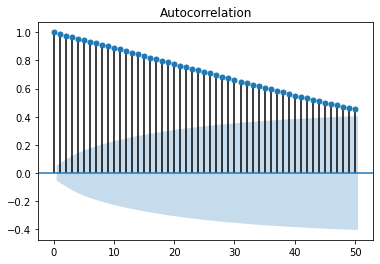

In [9]:
###### ASSESS IF PAST PRICES CAN PREDICT CURRENT PRICE

# Plot autocorrelation function (ACF)
# Note to Rim and Quinn: Autocorrelation assesses the link 
# between the current price and the past prices (lags) for a stock.
# Significant ACFs are blue dots out of the blue confidence interval.
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
plotACF=symbolFolder+"/plot_ACF_"+symbol+".pdf"
plot_acf(priceClose,lags=50)
pyplot.savefig(plotACF, bbox_inches='tight')
pyplot.show()

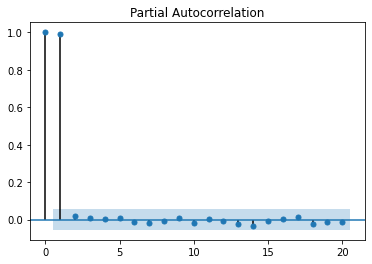

In [10]:
# Plot partial autocorrelations (PACF)
# Note to Rim and Quinn: It's the same as autocorrelations but after removal of the effects of each lag.
# Basically, PACF allows to identify which lags do have predictive power. 
# Significant PACFs are blue dots out of the blue confidence interval.
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
plotPACF=symbolFolder+"/plot_PACF_"+symbol+".pdf"
plot_pacf(priceClose,lags=20)
pyplot.savefig(plotPACF, bbox_inches='tight')
pyplot.show()

In [11]:
# Test autocorrelation residuals
ljungbox_lag5=acorr_ljungbox(priceClose, lags=[5], return_df=True)
ljungbox_lag10=acorr_ljungbox(priceClose, lags=[10], return_df=True)
ljungbox_lag15=acorr_ljungbox(priceClose, lags=[15], return_df=True)
print(ljungbox_lag5) # If pvalue < 5%, there is significant autocorrelation for lag=5
print(ljungbox_lag10) # If pvalue < 5%, there is significant autocorrelation for lag=10
print(ljungbox_lag15) # If pvalue < 5%, there is significant autocorrelation for lag=15

       lb_stat  lb_pvalue
5  5981.820746        0.0
         lb_stat  lb_pvalue
10  11322.302515        0.0
         lb_stat  lb_pvalue
15  16048.914798        0.0


In [12]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
# Note to Rim and Quinn: train data will be used only to build the model, 
# and test data will be used only to assess forecasting accuracy of the model.
priceCloseTrain = priceClose[0:(len(priceClose)-kdays)]
priceCloseTest = priceClose[(len(priceClose)-kdays):len(priceClose)]
print(priceCloseTrain)
print(priceCloseTest[0:5])

quotedate
2015-05-01    557.029999
2015-05-04    554.900017
2015-05-05    565.549980
2015-05-06    560.539986
2015-05-07    565.240013
                 ...    
2020-04-09    370.811000
2020-04-13    396.720000
2020-04-14    413.550000
2020-04-15    426.750000
2020-04-16    439.170000
Name: close, Length: 1248, dtype: float64
quotedate
2020-04-17    422.96
2020-04-20    437.49
2020-04-21    433.83
2020-04-22    421.42
2020-04-23    426.70
Name: close, dtype: float64


In [13]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
# Note to Rim and Quinn: Finding the best model is called model selection in statistics
# Here I built (or trained) the ARIMA model using training data. This is very important to prevent overfitting.
# auto_arima starts with a simple ARIMA model and then iteratively increases or decreases the model complexity.
# auto_arima stops when the current ARIMA model does not improve compared to the previous ARIMA model.
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=10808.930, BIC=10839.701, Time=0.718 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10804.185, BIC=10814.442, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=10805.501, BIC=10820.887, Time=0.045 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10805.458, BIC=10820.843, Time=0.090 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=10802.218, BIC=10807.346, Time=0.016 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10806.135, BIC=10826.649, Time=0.259 seconds
Total fit time: 1.154 seconds


In [14]:
# Results from auto_arima
# Note to Rim and Quinn: The ARIMA model with the lowest AIC (Akaike Information Criterion) is selected.
# Basically, AIC seeks for the best model fit, while also looking for model parcimony, 
# (less complex model = higher parcimony). 
# There are other criteria that can be used such as BIC and HQIC. AIC is preferred here.
# order=(X, X, X) is the ARIMA model selected.
print(autoARIMA)

ARIMA(order=(0, 1, 0), suppress_warnings=True, with_intercept=False)


In [15]:
# Details of the selected ARIMA model
# Note to Rim and Quinn: You can find the AIC value of the selected model. 
# Important information from the summary: the coef table.
# In the coef table, you see the parameter coef of the model and the associated p-value.
# ar.L1 is the autoregressive parameter of lag=1. If present.
# ma.L1 is the moving average parameter of lag=1. If present.
print(autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1248
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5400.109
Date:                Mon, 15 Jun 2020   AIC                          10802.218
Time:                        16:04:09   BIC                          10807.346
Sample:                             0   HQIC                         10804.146
                               - 1248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       338.0141      0.626    540.238      0.000     336.788     339.240
Ljung-Box (Q):                       11.32   Jarque-Bera (JB):          45461865.87
Prob(Q):                              1.00   Pr

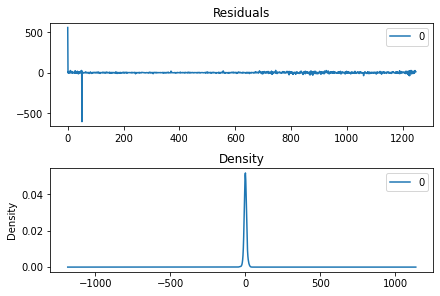

In [16]:
###### CHECK MODEL ASSUMPTIONS

# Plot residual errors
# Note to Rim and Quinn: For the ARIMA model to be valid, 
# the residual errors should be near zero mean and present uniform variance. 
plotResiduals=symbolFolder+"/plot_ARIMA_residuals_"+symbol+".pdf"
residuals=pd.DataFrame(autoARIMA.resid())
fig, ax = pyplot.subplots(2,constrained_layout=True)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
pyplot.savefig(plotResiduals, bbox_inches='tight')
pyplot.show()

In [17]:
###### FORECAST PRICE USING ARIMA MODEL

# Forecast with confidence interval (alpha=5%)
future_forecast, conf_int = autoARIMA.predict(n_periods=kdays,return_conf_int=True,alpha=0.05)
future_forecast = pd.DataFrame(future_forecast,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)

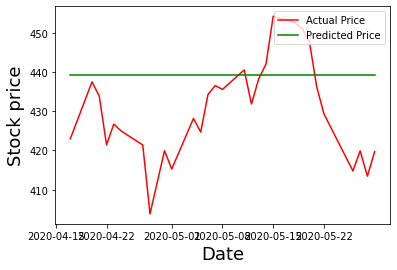

In [18]:
# Simple forecast plot
plotForeCastSimple=symbolFolder+"/plot_ARIMA_forecast_simple_"+symbol+".pdf"
pyplot.plot(priceCloseTest, 'r', label='Actual Price') # plotting t, a separately 
pyplot.plot(future_forecast, 'g', label='Predicted Price') # plotting t, b separately 
pyplot.legend(loc='upper right')
pyplot.xlabel('Date', fontsize=18)
pyplot.ylabel('Stock price', fontsize=18)
pyplot.savefig(plotForeCastSimple, bbox_inches='tight')
pyplot.show()

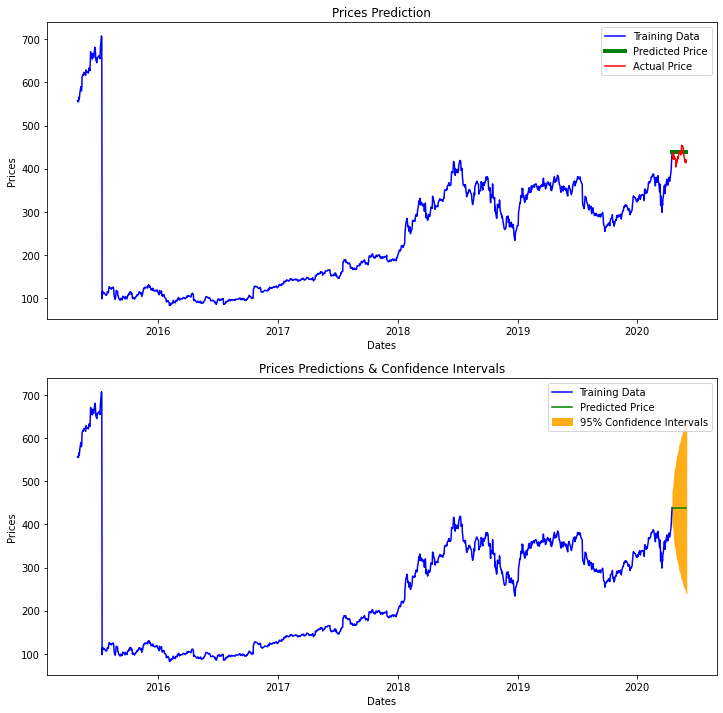

In [19]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')

mu=439.17
SE=100.7


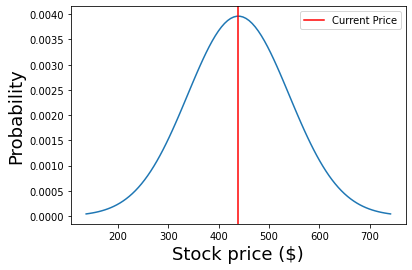

In [20]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()